## MLFLOW для экспериментов с Sklearn

In [1]:
import os
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Загрузка данных Титаника из csv-файла
data = pd.read_csv('titanic.csv')
data = data [['Survived','Pclass','Age','Fare']]
data = data.dropna(subset=['Age'])

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    int64  
 1   Pclass    714 non-null    int64  
 2   Age       714 non-null    float64
 3   Fare      714 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 27.9 KB


In [3]:
# Укажем юзера который делает эксперименты
os.environ['USER'] = 'Dima Kolesnikov'

In [ ]:
# Разделение данных на обучающую и тестовую выборки
train, test = train_test_split(data, test_size=0.2)

# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5050")
mlflow.set_experiment("TreeClassifier_test")

<Experiment: artifact_location='file:///C:/ML_flow_server/artefacts/357912134396860748', creation_time=1730708874112, experiment_id='357912134396860748', last_update_time=1730708874112, lifecycle_stage='active', name='TreeClassifier_test', tags={}>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Функция для построения матрицы ошибок.
    cm - матрица ошибок
    classes - список классов
    normalize - если True, то значения матрицы ошибок нормализуются к 1
    title - заголовок графика
    cmap - цветовая схема для отображения графика
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
# Запуск контекста MLflow и сохранение гиперпараметров
def experiment(run_name, max_depth, min_samples_split):
    with mlflow.start_run(run_name=run_name):

        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("min_samples_split", min_samples_split)

        # Создание и обучение модели решающего дерева
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        model.fit(train.drop('Survived', axis=1), train['Survived'])

        # Вычисление метрик и сохранение их в MLflow
        preds = model.predict(test.drop('Survived', axis=1))
        acc = accuracy_score(test['Survived'], preds)
        cm = confusion_matrix(test['Survived'], preds)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("tn", cm[0][0])
        mlflow.log_metric("fp", cm[0][1])
        mlflow.log_metric("fn", cm[1][0])
        mlflow.log_metric("tp", cm[1][1])

        # Визуализация матрицы ошибок и сохранение ее в MLflow
        plot_confusion_matrix(cm, classes=['Not Survived', 'Survived'])
        cm_fig = plt.gcf()
        cm_fig.savefig('matrix.png')

        mlflow.log_artifact("matrix.png")

        # Сохранение модели в MLflow
        mlflow.sklearn.log_model(model, "model")   
    mlflow.end_run()

Confusion matrix, without normalization


2024/11/04 11:42:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/04 11:42:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run DecisionTreeClassifier_run at: http://localhost:5000/#/experiments/357912134396860748/runs/04b0593e534948bf862bf57cbf278482.
2024/11/04 11:42:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/357912134396860748.


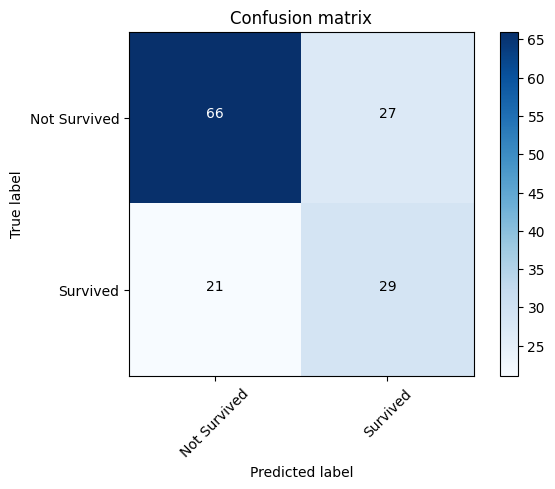

In [10]:
# Определение гиперпараметров модели
max_depth = 10
min_samples_split = 25
run_name = 'DecisionTreeClassifier_run'

experiment(run_name, max_depth, min_samples_split)